In [ ]:

import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
from keras.layers import Input,Dense,Reshape,Conv2D,Dropout,multiply,Dot,Concatenate,subtract,ZeroPadding2D
from keras.layers import BatchNormalization,LeakyReLU,Flatten
from keras.layers import Conv2DTranspose as Deconv2d
from keras.models import Model
from keras.optimizers import Adam

from google.colab import files
from keras import backend as K
import smtplib

from sklearn.utils import shuffle
from google.colab import drive




In [ ]:
def plot(A,B,C,n):

    samples = [A,B,C]
    fig = plt.figure(figsize=(3,n))
    gs = gridspec.GridSpec(3,n)
    g=0
    for i in range(3):
        for j in range(n):
            ax = plt.subplot(gs[g])
            g+=1
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            if samples[i][j].shape == (32,32,1):
              plt.imshow(samples[i][j].reshape(32, 32))
            else:
              plt.imshow(samples[i][j].reshape(32,32,3))

    return fig

In [ ]:
#for plotting any two images in case

def ploty(A,B,n):

    samples = [A,B]
    fig = plt.figure(figsize=(3,n))
    gs = gridspec.GridSpec(3,n)
    g=0
    for i in range(2):
        for j in range(n):
            ax = plt.subplot(gs[g])
            g+=1
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            if samples[i][j].shape == (32,32,1):
              plt.imshow(samples[i][j].reshape(32, 32, 1))
            else:
              plt.imshow(samples[i][j].reshape(32,32,3))

    return fig

In [ ]:
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

y=x_train
x=np.sum(y, axis=3)/(3*255)

y_test=x_test
x_test=np.sum(x_test, axis=3)/(3*255)   #for converting RGB into singe channel
x_test=x_test.reshape(10000, 32, 32, 1)


y=x_train/255
y=y*2-1


#x=x*2-1
#x=np.dot(y[...,:3], [0.299, 0.587, 0.114])/255
#x=x.reshape(50000,32, 32,1)

x=x.reshape(50000, 32, 32, 1)

print(x.shape)
print(y.shape)
  

(50000, 32, 32, 1)
(50000, 32, 32, 3)


In [ ]:
  
x_shape=(32,32,1)
y_shape=(32,32,3)

In [ ]:
def Generator():
  X = Input(shape = x_shape)
  
  #C1 = ZeroPadding2D(padding=(1,1))(X)  
  C1 = Conv2D(64,kernel_size = 1, strides = 1,input_shape = x_shape)(X)
  C1 = LeakyReLU(0.2)(C1)
  
  C2 = Conv2D(128,kernel_size = 2, strides = 2)(C1)  
  C2 = LeakyReLU(0.2)(C2)
  
  C3 = Conv2D(256,kernel_size = 2, strides = 2)(C2)
  C3 = LeakyReLU(0.2)(C3)
  
  C4 = Conv2D(512,kernel_size = 2, strides = 2)(C3)
  C4 = LeakyReLU(0.2)(C4)

  C5 = Conv2D(512, kernel_size = 2, strides = 2)(C4)
  C5 = LeakyReLU(0.2)(C5)
  
  
  DC0 = Deconv2d(512, kernel_size = 2, strides = 2)(C5)
  DC0 = LeakyReLU(0.2)(DC0)
  DC0 = BatchNormalization()(DC0)
  DC0 = Dropout(0.5)(DC0)
  DC0 = Concatenate(axis=3)([DC0, C4])

  
  DC1 = Deconv2d(256,kernel_size=2, strides = 2)(DC0)
  DC1 = LeakyReLU(0.2)(DC1)
  DC1 = BatchNormalization()(DC1)  
  DC1 = Dropout(0.5)(DC1)             
  DC1 = Concatenate(axis=3)([DC1,C3])

  
  DC2 = Deconv2d(128,kernel_size=2, strides = 2)(DC1)
  DC2 = LeakyReLU(0.2)(DC2)
  DC2 = BatchNormalization()(DC2)  
  DC2 = Concatenate(axis=3)([DC2,C2])
  
  DC3 = Deconv2d(64,kernel_size=2, strides = 2)(DC2)
  DC3 = LeakyReLU(0.2)(DC3)
  DC3 = BatchNormalization()(DC3)  
  DC3 = Concatenate(axis=3)([DC3,C1])
  
  #DC4 = ZeroPadding2D(padding=(3,1))(DC3)  
  CC4 = Conv2D(3,kernel_size=(1, 1), strides = (1, 1), activation="tanh")(DC3)
  
  m = Model(X,CC4)
  #m.summary()
  return m
  

In [ ]:
def Discriminator():
  X = Input(shape = x_shape)
  Y = Input(shape = y_shape)
  
  In = Concatenate(axis=3)([X,Y])
  
  C1 = Conv2D(64,kernel_size = 2, strides = 2,input_shape = x_shape)(In)
  C1 = BatchNormalization()(C1)
  C1 = LeakyReLU(0.2)(C1)
  C2 = Conv2D(128,kernel_size = 2, strides = 2)(C1)  
  C2 = BatchNormalization()(C2)
  C2 = LeakyReLU(0.2)(C2)
  
  C3 = Conv2D(256,kernel_size = 2, strides = 2)(C2)
  C3 = BatchNormalization()(C3)
  C3 = LeakyReLU(0.2)(C3)
  
  C4 = Conv2D(512,kernel_size = 1, strides = 1)(C3)
  C4 = BatchNormalization()(C4)
  C4 = LeakyReLU(0.2)(C4)
  
  D = Flatten()(C4)
  D = Dense(128)(D)
  D = Dense(1,activation='sigmoid')(D)
  
  m = Model([X,Y],D)
  #m.summary()
  return m
   



In [ ]:
X = Input(shape = x_shape)
Y = Input(shape = y_shape)

gen = Generator()
dis = Discriminator()

out = gen(X)
comb = dis([X,out])

out = Flatten()(out)
org = Flatten()(Y)

cos_dis = Dot(axes = 1,normalize = True)([out,org])

combined = Model([X,Y],[comb,cos_dis])

In [ ]:
genLoss=[]
disLoss=[]

In [ ]:
epochs = 300
batch_size = 50
n_example = 50000
batches = int(n_example/batch_size)
dis_updates = 2
gen_updates = 1
zero=np.zeros((batch_size,1))
one=np.ones((batch_size,1))*0.9
d_loss_factor = batches*2*dis_updates
g_loss_factor = batches*gen_updates
reuse = False
adams = Adam(lr = 0.0001)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#location in drive where models are present.

if(reuse == True):
  gen.load_weights("gdrive/My Drive/newGAN/Generator.h5")
  dis.load_weights("gdrive/My Drive/newGAN/Discriminator.h5")

##############
For Epoch:0
Training Discriminator
Training Generator
Discriminator Loss:0.19814105361876863
Generator loss:0.778773611843586


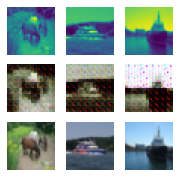

##############
For Epoch:1
Training Discriminator
Training Generator
Discriminator Loss:0.171777825690353
Generator loss:0.6877833776473999


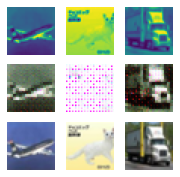

##############
For Epoch:2
Training Discriminator
Training Generator
Discriminator Loss:0.16905619304693392
Generator loss:0.6746961051225662


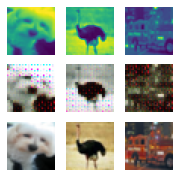

##############
For Epoch:3
Training Discriminator
Training Generator
Discriminator Loss:0.16865165556801823
Generator loss:0.6714169817566872


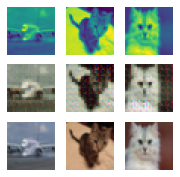

##############
For Epoch:4
Training Discriminator
Training Generator
Discriminator Loss:0.16617982725967295
Generator loss:0.6703160439133644


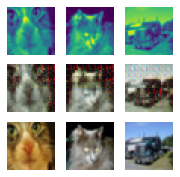

##############
For Epoch:5
Training Discriminator
Training Generator
Discriminator Loss:0.16526392133277523
Generator loss:0.6695899360775948


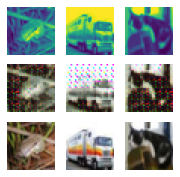

##############
For Epoch:6
Training Discriminator
Training Generator
Discriminator Loss:0.1646019394608579
Generator loss:0.6682631268501281


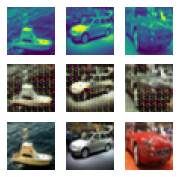

##############
For Epoch:7
Training Discriminator
Training Generator
Discriminator Loss:0.16448837090499047
Generator loss:0.6687078652381897


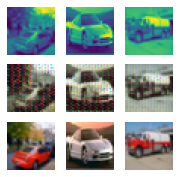

##############
For Epoch:8
Training Discriminator
Training Generator
Discriminator Loss:0.16395669596262086
Generator loss:0.6668409742712974


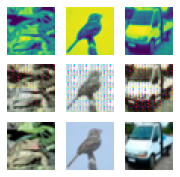

##############
For Epoch:9
Training Discriminator
Training Generator
Discriminator Loss:0.16413044053201883
Generator loss:0.6670100893378258


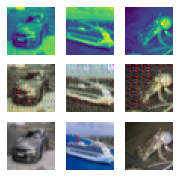

##############
For Epoch:10
Training Discriminator
Training Generator
Discriminator Loss:0.16375692871040246
Generator loss:0.6680392519831657


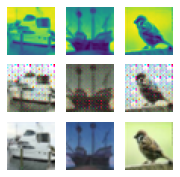

##############
For Epoch:11
Training Discriminator
Training Generator
Discriminator Loss:0.16370143593601597
Generator loss:0.6669676401615143


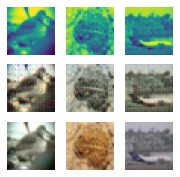

##############
For Epoch:12
Training Discriminator
Training Generator
Discriminator Loss:0.16343005867919919
Generator loss:0.6681537786722184


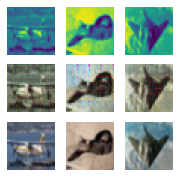

##############
For Epoch:13
Training Discriminator
Training Generator
Discriminator Loss:0.16315842013431417
Generator loss:0.6659759212732315


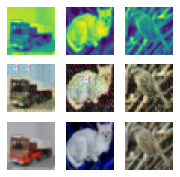

##############
For Epoch:14
Training Discriminator
Training Generator
Discriminator Loss:0.16293760811475477
Generator loss:0.6669942255020141


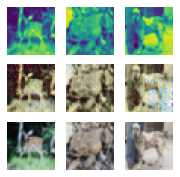

##############
For Epoch:15
Training Discriminator
Training Generator
Discriminator Loss:0.16301204945106065
Generator loss:0.6676187703609466


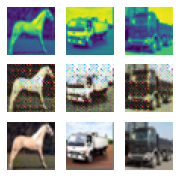

##############
For Epoch:16
Training Discriminator
Training Generator
Discriminator Loss:0.16346807380914175
Generator loss:0.6665612952709198


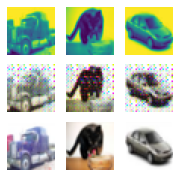

##############
For Epoch:17
Training Discriminator
Training Generator
Discriminator Loss:0.16325533153577498
Generator loss:0.6659131754040718


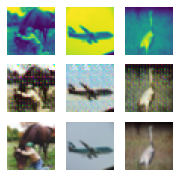

##############
For Epoch:18
Training Discriminator
Training Generator
Discriminator Loss:0.16298972619431423
Generator loss:0.6654007331132888


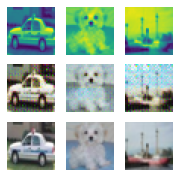

##############
For Epoch:19
Training Discriminator
Training Generator
Discriminator Loss:0.16279406959668585
Generator loss:0.6674788011908531


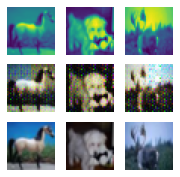

##############
For Epoch:20
Training Discriminator
Training Generator
Discriminator Loss:0.1627797120953369
Generator loss:0.6672760525941849


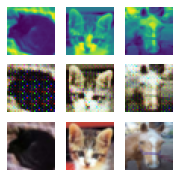

##############
For Epoch:21
Training Discriminator
Training Generator
Discriminator Loss:0.16272136345604646
Generator loss:0.6655000850558281


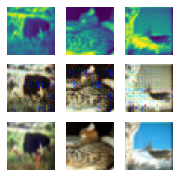

##############
For Epoch:22
Training Discriminator
Training Generator
Discriminator Loss:0.1628963509979842
Generator loss:0.66393755453825


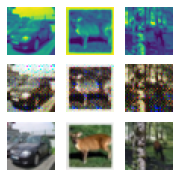

##############
For Epoch:23
Training Discriminator
Training Generator
Discriminator Loss:0.16271540497934212
Generator loss:0.6639790980815887


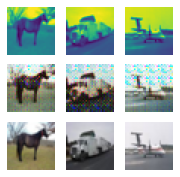

##############
For Epoch:24
Training Discriminator
Training Generator
Discriminator Loss:0.16266504103415322
Generator loss:0.6634942746758461


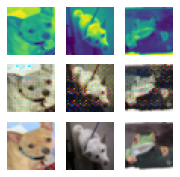

##############
For Epoch:25
Training Discriminator
Training Generator
Discriminator Loss:0.16268841999055564
Generator loss:0.6625929390192031


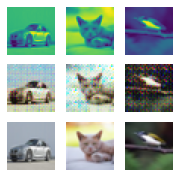

##############
For Epoch:26
Training Discriminator
Training Generator
Discriminator Loss:0.1626587100384001
Generator loss:0.6628365290164947


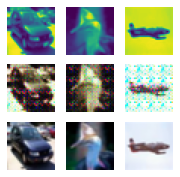

##############
For Epoch:27
Training Discriminator
Training Generator
Discriminator Loss:0.16263692997616114
Generator loss:0.6620117810368538


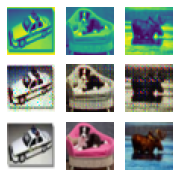

##############
For Epoch:28
Training Discriminator
Training Generator
Discriminator Loss:0.16265820724866314
Generator loss:0.6626939827799797


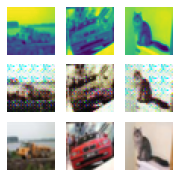

##############
For Epoch:29
Training Discriminator
Training Generator
Discriminator Loss:0.16264067204947208
Generator loss:0.6625077655315399


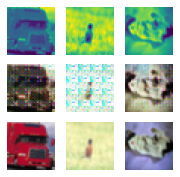

##############
For Epoch:30
Training Discriminator
Training Generator
Discriminator Loss:0.1626540961115935
Generator loss:0.6628037512302398


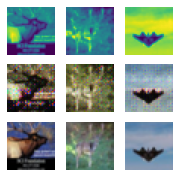

##############
For Epoch:31
Training Discriminator
Training Generator
Discriminator Loss:0.16262661833694597
Generator loss:0.662138510286808


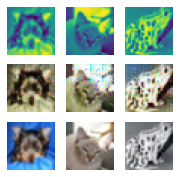

##############
For Epoch:32
Training Discriminator
Training Generator
Discriminator Loss:0.16263284859543733
Generator loss:0.662134868323803


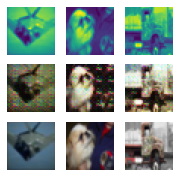

##############
For Epoch:33
Training Discriminator
Training Generator
Discriminator Loss:0.16261631450795155
Generator loss:0.6616896961927414


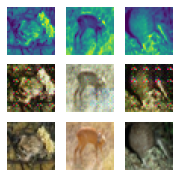

##############
For Epoch:34
Training Discriminator
Training Generator
Discriminator Loss:0.16263338744546924
Generator loss:0.6644671894907951


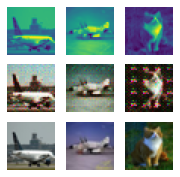

##############
For Epoch:35
Training Discriminator
Training Generator
Discriminator Loss:0.16259586727852998
Generator loss:0.6623015034198761


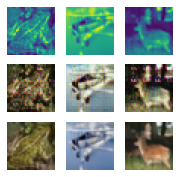

##############
For Epoch:36
Training Discriminator
Training Generator
Discriminator Loss:0.1625911700690586
Generator loss:0.661656416118145


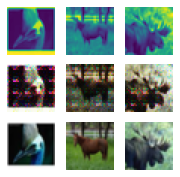

##############
For Epoch:37
Training Discriminator
Training Generator
Discriminator Loss:0.16260707348345996
Generator loss:0.6611714144945144


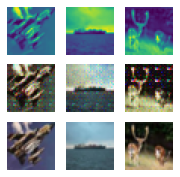

##############
For Epoch:38
Training Discriminator
Training Generator
Discriminator Loss:0.16260631092546085
Generator loss:0.6612307761907578


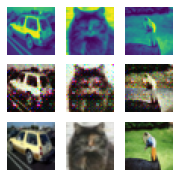

##############
For Epoch:39
Training Discriminator
Training Generator
Discriminator Loss:0.16260030423433106
Generator loss:0.6615622432231903


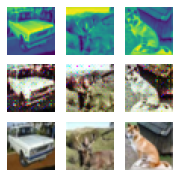

##############
For Epoch:40
Training Discriminator
Training Generator
Discriminator Loss:0.16259315100216665
Generator loss:0.6619384713768959


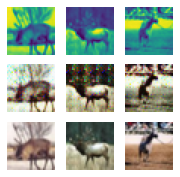

##############
For Epoch:41
Training Discriminator
Training Generator
Discriminator Loss:0.1625997917644902
Generator loss:0.6608040306568146


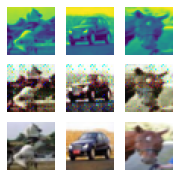

##############
For Epoch:42
Training Discriminator
Training Generator
Discriminator Loss:0.1626453211514325
Generator loss:0.661729862511158


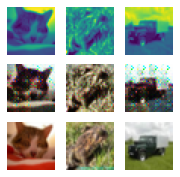

##############
For Epoch:43
Training Discriminator
Training Generator
Discriminator Loss:0.1626148892856218
Generator loss:0.6619745656847954


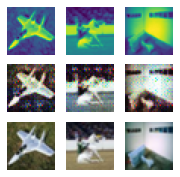

##############
For Epoch:44
Training Discriminator
Training Generator
Discriminator Loss:0.16265567372378636
Generator loss:0.6610706906914711


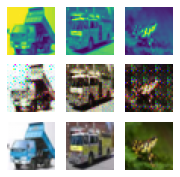

##############
For Epoch:45
Training Discriminator
Training Generator
Discriminator Loss:0.16258885358392874
Generator loss:0.6608558842539787


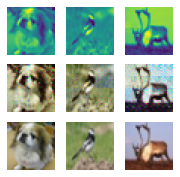

##############
For Epoch:46
Training Discriminator
Training Generator
Discriminator Loss:0.16263821962010155
Generator loss:0.6610386955738068


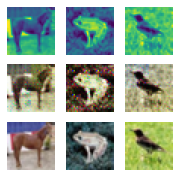

##############
For Epoch:47
Training Discriminator
Training Generator
Discriminator Loss:0.1625804439824433
Generator loss:0.6607301453351975


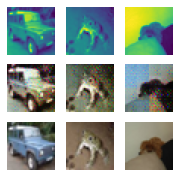

##############
For Epoch:48
Training Discriminator
Training Generator
Discriminator Loss:0.16259066956126467
Generator loss:0.6597552841901779


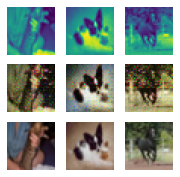

##############
For Epoch:49
Training Discriminator
Training Generator
Discriminator Loss:0.1625877567179647
Generator loss:0.6597443943023682


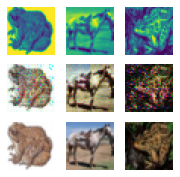

##############
For Epoch:50
Training Discriminator
Training Generator
Discriminator Loss:0.16257927483187756
Generator loss:0.6590721217393876


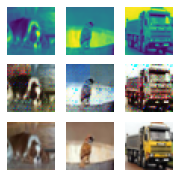

##############
For Epoch:51
Training Discriminator
Training Generator
Discriminator Loss:0.16258127628881297
Generator loss:0.6598089327812194


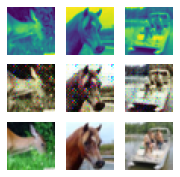

##############
For Epoch:52
Training Discriminator
Training Generator
Discriminator Loss:0.16265505247156956
Generator loss:0.6584034032225609


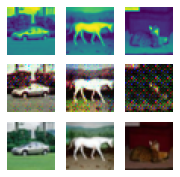

##############
For Epoch:53
Training Discriminator
Training Generator
Discriminator Loss:0.16257910618272983
Generator loss:0.6591876873970032


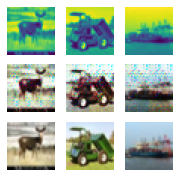

##############
For Epoch:54
Training Discriminator
Training Generator
Discriminator Loss:0.162570037377957
Generator loss:0.6584570066332817


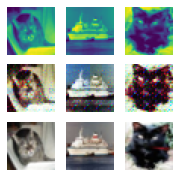

##############
For Epoch:55
Training Discriminator
Training Generator
Discriminator Loss:0.16257367238149428
Generator loss:0.6587580569982529


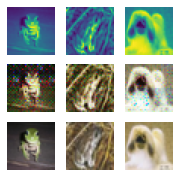

##############
For Epoch:56
Training Discriminator
Training Generator
Discriminator Loss:0.16257971125999765
Generator loss:0.6583824208974838


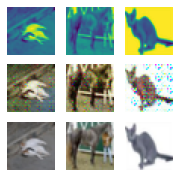

##############
For Epoch:57
Training Discriminator
Training Generator
Discriminator Loss:0.16257522771611194
Generator loss:0.65853547590971


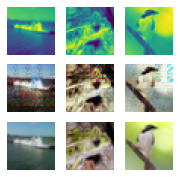

##############
For Epoch:58
Training Discriminator
Training Generator
Discriminator Loss:0.1625723154613476
Generator loss:0.6579145886301995


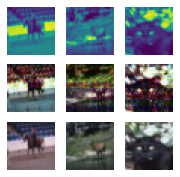

##############
For Epoch:59
Training Discriminator
Training Generator
Discriminator Loss:0.16260127759712098
Generator loss:0.658155563890934


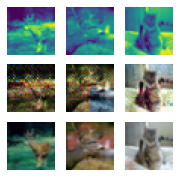

##############
For Epoch:60
Training Discriminator
Training Generator
Discriminator Loss:0.1625836329795897
Generator loss:0.6578471511006355


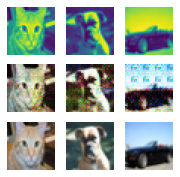

##############
For Epoch:61
Training Discriminator
Training Generator
Discriminator Loss:0.16256840167500117
Generator loss:0.6572627196907997


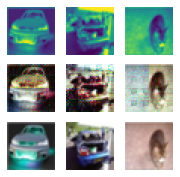

##############
For Epoch:62
Training Discriminator
Training Generator
Discriminator Loss:0.1625648868350405
Generator loss:0.6623157586455345


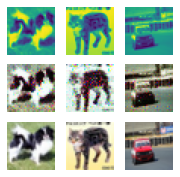

##############
For Epoch:63
Training Discriminator
Training Generator
Discriminator Loss:0.16257265002433532
Generator loss:0.6640364342331886


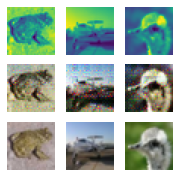

##############
For Epoch:64
Training Discriminator
Training Generator
Discriminator Loss:0.1625631683501278
Generator loss:0.6610521951913834


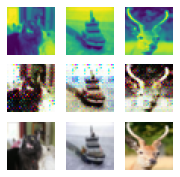

##############
For Epoch:65
Training Discriminator
Training Generator
Discriminator Loss:0.1625686266665434
Generator loss:0.6586175863742828


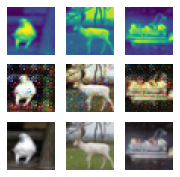

##############
For Epoch:66
Training Discriminator
Training Generator
Discriminator Loss:0.16257420355427402
Generator loss:0.6583028512597084


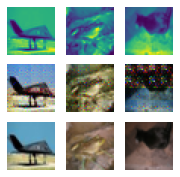

##############
For Epoch:67
Training Discriminator
Training Generator
Discriminator Loss:0.1625705502424938
Generator loss:0.657889757335186


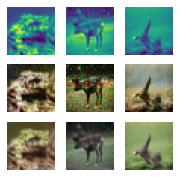

##############
For Epoch:68
Training Discriminator
Training Generator
Discriminator Loss:0.16256570459842548
Generator loss:0.6575611977577209


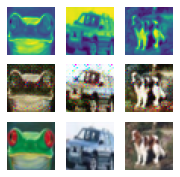

##############
For Epoch:69
Training Discriminator
Training Generator
Discriminator Loss:0.16256216480349966
Generator loss:0.6570521112680435


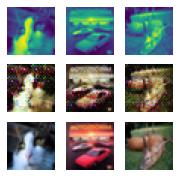

##############
For Epoch:70
Training Discriminator
Training Generator
Discriminator Loss:0.1625616082998679
Generator loss:0.6563767840862275


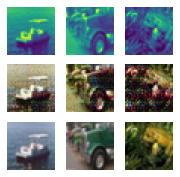

##############
For Epoch:71
Training Discriminator
Training Generator
Discriminator Loss:0.16256258542667637
Generator loss:0.6560434748530388


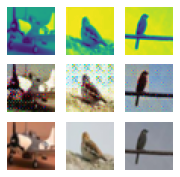

##############
For Epoch:72
Training Discriminator
Training Generator
Discriminator Loss:0.16256423060372055
Generator loss:0.655725573182106


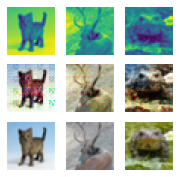

##############
For Epoch:73
Training Discriminator
Training Generator
Discriminator Loss:0.16256321468375046
Generator loss:0.6557418343424797


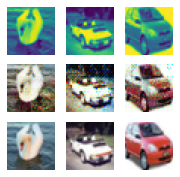

##############
For Epoch:74
Training Discriminator
Training Generator
Discriminator Loss:0.16257015323188131
Generator loss:0.655695731818676


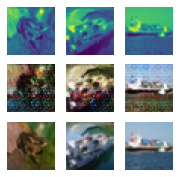

##############
For Epoch:75
Training Discriminator
Training Generator
Discriminator Loss:0.16256619526836735
Generator loss:0.6551804326176643


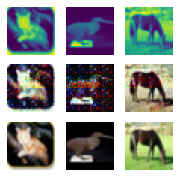

##############
For Epoch:76
Training Discriminator
Training Generator
Discriminator Loss:0.1625611663270809
Generator loss:0.6548117373585701


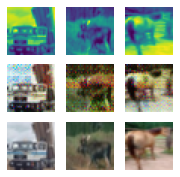

##############
For Epoch:77
Training Discriminator
Training Generator
Discriminator Loss:0.16255909152656833
Generator loss:0.654942016005516


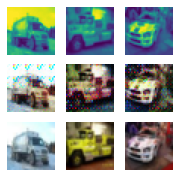

##############
For Epoch:78
Training Discriminator
Training Generator
Discriminator Loss:0.1625576178722947
Generator loss:0.6544517666697502


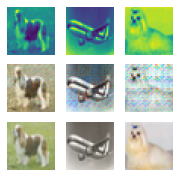

##############
For Epoch:79
Training Discriminator
Training Generator
Discriminator Loss:0.16256405122277073
Generator loss:0.6543550681471825


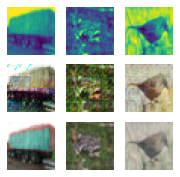

##############
For Epoch:80
Training Discriminator
Training Generator
Discriminator Loss:0.16256487050258372
Generator loss:0.6540441932678223


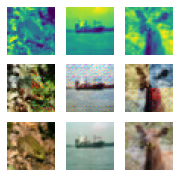

##############
For Epoch:81
Training Discriminator
Training Generator
Discriminator Loss:0.16256529520349236
Generator loss:0.653989221572876


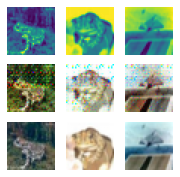

##############
For Epoch:82
Training Discriminator
Training Generator
Discriminator Loss:0.1625585784624939
Generator loss:0.6538380901217461


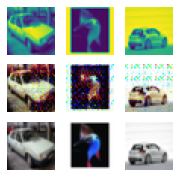

##############
For Epoch:83
Training Discriminator
Training Generator
Discriminator Loss:0.1625585544312669
Generator loss:0.6538077024817467


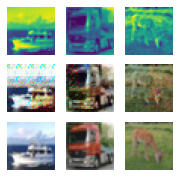

##############
For Epoch:84
Training Discriminator
Training Generator
Discriminator Loss:0.16256165354016786
Generator loss:0.6536863370537758


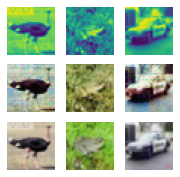

##############
For Epoch:85
Training Discriminator
Training Generator
Discriminator Loss:0.16255488491329537
Generator loss:0.6538631772994995


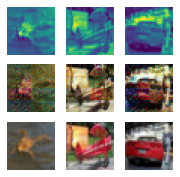

##############
For Epoch:86
Training Discriminator
Training Generator
Discriminator Loss:0.16257978254570377
Generator loss:0.6534876411557198


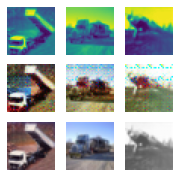

##############
For Epoch:87
Training Discriminator
Training Generator
Discriminator Loss:0.1625558003462435
Generator loss:0.6537139122486114


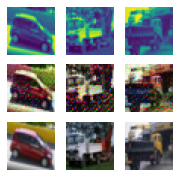

##############
For Epoch:88
Training Discriminator
Training Generator
Discriminator Loss:0.1625553722841905
Generator loss:0.6532007768750191


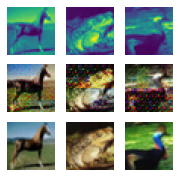

##############
For Epoch:89
Training Discriminator
Training Generator
Discriminator Loss:0.16257123536040052
Generator loss:0.6533421704769135


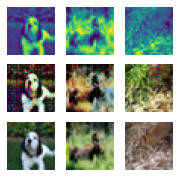

##############
For Epoch:90
Training Discriminator
Training Generator
Discriminator Loss:0.16255664921276275
Generator loss:0.6530309845805168


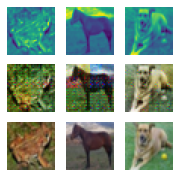

##############
For Epoch:91
Training Discriminator
Training Generator
Discriminator Loss:0.16255615205173302
Generator loss:0.6531676343679428


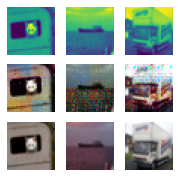

##############
For Epoch:92
Training Discriminator
Training Generator
Discriminator Loss:0.1625550924689438
Generator loss:0.6529251960515976


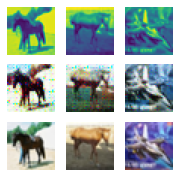

##############
For Epoch:93
Training Discriminator
Training Generator
Discriminator Loss:0.16255684112789476
Generator loss:0.6533749557137489


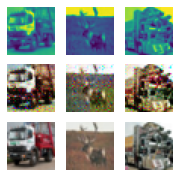

##############
For Epoch:94
Training Discriminator
Training Generator
Discriminator Loss:0.16255741507105428
Generator loss:0.6535313881635666


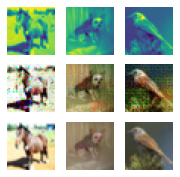

##############
For Epoch:95
Training Discriminator
Training Generator
Discriminator Loss:0.16255586744079184
Generator loss:0.6532254918217659


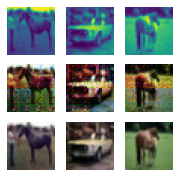

##############
For Epoch:96
Training Discriminator
Training Generator
Discriminator Loss:0.16255826687380948
Generator loss:0.6531867744922638


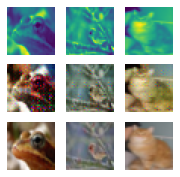

##############
For Epoch:97
Training Discriminator
Training Generator
Discriminator Loss:0.16255381867413882
Generator loss:0.6535595272183419


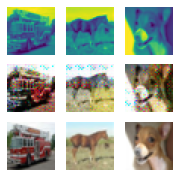

##############
For Epoch:98
Training Discriminator
Training Generator
Discriminator Loss:0.16257115732587032
Generator loss:0.652983590900898


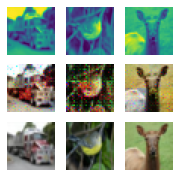

##############
For Epoch:99
Training Discriminator
Training Generator
Discriminator Loss:0.16255643959991406
Generator loss:0.6526539323925972


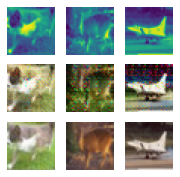

##############
For Epoch:100
Training Discriminator
Training Generator
Discriminator Loss:0.16256157033389076
Generator loss:0.6524575944542885


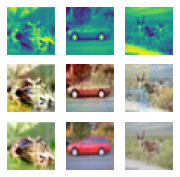

##############
For Epoch:101
Training Discriminator
Training Generator
Discriminator Loss:0.16258789602305063
Generator loss:0.6530148315429688


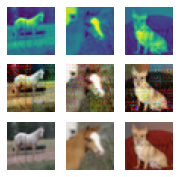

##############
For Epoch:102
Training Discriminator
Training Generator
Discriminator Loss:0.16255278756891442
Generator loss:0.6526338379979134


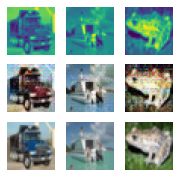

##############
For Epoch:103
Training Discriminator
Training Generator
Discriminator Loss:0.16255218576487757
Generator loss:0.6523334069252014


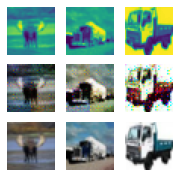

##############
For Epoch:104
Training Discriminator
Training Generator
Discriminator Loss:0.16255411161379132
Generator loss:0.6523141945004464


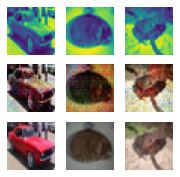

##############
For Epoch:105
Training Discriminator
Training Generator
Discriminator Loss:0.16255346376939314
Generator loss:0.6523938274979592


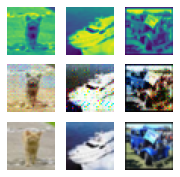

##############
For Epoch:106
Training Discriminator
Training Generator
Discriminator Loss:0.16255163657229332
Generator loss:0.6522154802680016


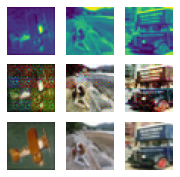

##############
For Epoch:107
Training Discriminator
Training Generator
Discriminator Loss:0.16255338969798167
Generator loss:0.6523539279103279


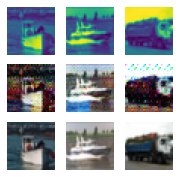

##############
For Epoch:108
Training Discriminator
Training Generator
Discriminator Loss:0.1625500353245203
Generator loss:0.6523280453681946


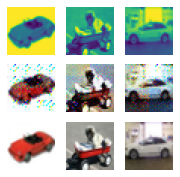

##############
For Epoch:109
Training Discriminator
Training Generator
Discriminator Loss:0.1625527833163286
Generator loss:0.6527195199728012


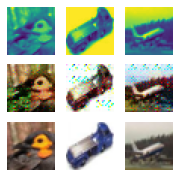

##############
For Epoch:110
Training Discriminator
Training Generator
Discriminator Loss:0.16255538108434675
Generator loss:0.6518918589353562


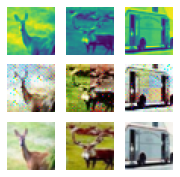

##############
For Epoch:111
Training Discriminator
Training Generator
Discriminator Loss:0.16255522894518043
Generator loss:0.6520844349861145


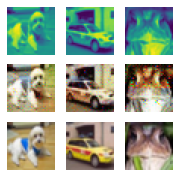

##############
For Epoch:112
Training Discriminator
Training Generator
Discriminator Loss:0.16255124181941488
Generator loss:0.6524676243066788


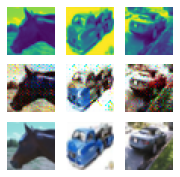

##############
For Epoch:113
Training Discriminator
Training Generator
Discriminator Loss:0.16255281430928684
Generator loss:0.6525207504034042


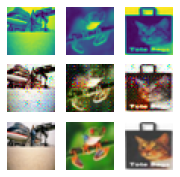

##############
For Epoch:114
Training Discriminator
Training Generator
Discriminator Loss:0.16254927162908017
Generator loss:0.6524201021790504


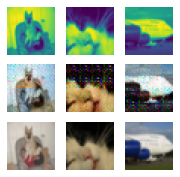

##############
For Epoch:115
Training Discriminator
Training Generator
Discriminator Loss:0.16254974365950392
Generator loss:0.6527541724443435


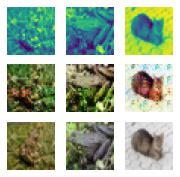

##############
For Epoch:116
Training Discriminator
Training Generator
Discriminator Loss:0.16255367617637634
Generator loss:0.6522349008321762


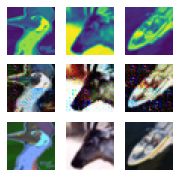

##############
For Epoch:117
Training Discriminator
Training Generator
Discriminator Loss:0.162552312054827
Generator loss:0.6524833000898361


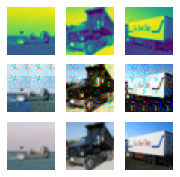

##############
For Epoch:118
Training Discriminator
Training Generator
Discriminator Loss:0.1625512383655394
Generator loss:0.6519957106709481


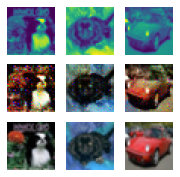

##############
For Epoch:119
Training Discriminator
Training Generator
Discriminator Loss:0.16255173014719676
Generator loss:0.652456337094307


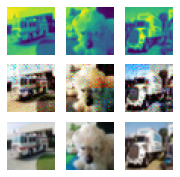

##############
For Epoch:120
Training Discriminator
Training Generator
Discriminator Loss:0.16255152872360773
Generator loss:0.6519328054785728


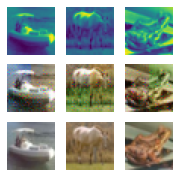

##############
For Epoch:121
Training Discriminator
Training Generator
Discriminator Loss:0.16255536434210618
Generator loss:0.6516651051640511


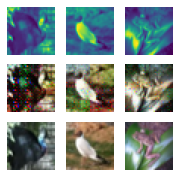

##############
For Epoch:122
Training Discriminator
Training Generator
Discriminator Loss:0.16255552741973442
Generator loss:0.6521991647481918


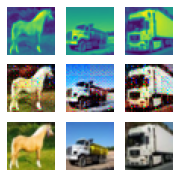

##############
For Epoch:123
Training Discriminator
Training Generator
Discriminator Loss:0.16254991574786698
Generator loss:0.6521097755432129


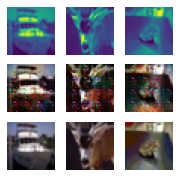

##############
For Epoch:124
Training Discriminator
Training Generator
Discriminator Loss:0.1625590378826057
Generator loss:0.6521720319390297


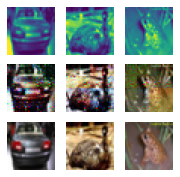

##############
For Epoch:125
Training Discriminator
Training Generator
Discriminator Loss:0.16255079197768885
Generator loss:0.6526550024747848


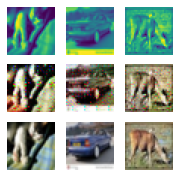

##############
For Epoch:126
Training Discriminator
Training Generator
Discriminator Loss:0.1625500190160918
Generator loss:0.6522048994302749


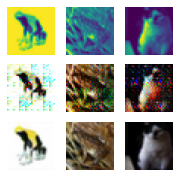

##############
For Epoch:127
Training Discriminator
Training Generator
Discriminator Loss:0.1625502293204743
Generator loss:0.6519079517126083


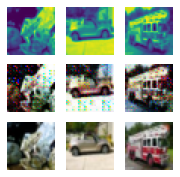

##############
For Epoch:128
Training Discriminator
Training Generator
Discriminator Loss:0.1625509267668222
Generator loss:0.6519036346077919


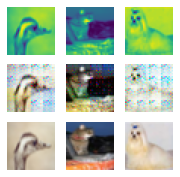

##############
For Epoch:129
Training Discriminator
Training Generator
Discriminator Loss:0.1625505411493666
Generator loss:0.6520321496725082


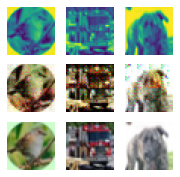

##############
For Epoch:130
Training Discriminator
Training Generator
Discriminator Loss:0.1625492926869145
Generator loss:0.6531371114253998


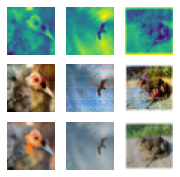

##############
For Epoch:131
Training Discriminator
Training Generator
Discriminator Loss:0.16254977122252998
Generator loss:0.6522849152088165


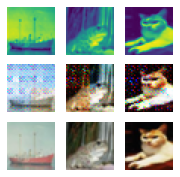

##############
For Epoch:132
Training Discriminator
Training Generator
Discriminator Loss:0.16254861759049025
Generator loss:0.6521977461576461


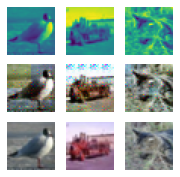

##############
For Epoch:133
Training Discriminator
Training Generator
Discriminator Loss:0.16255057848650853
Generator loss:0.65197397595644


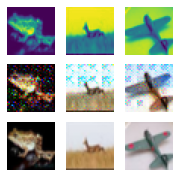

##############
For Epoch:134
Training Discriminator
Training Generator
Discriminator Loss:0.16254892822127973
Generator loss:0.6528053658604622


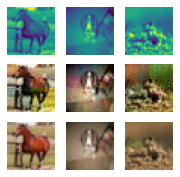

##############
For Epoch:135
Training Discriminator
Training Generator
Discriminator Loss:0.1625492278351298
Generator loss:0.6518114953041076


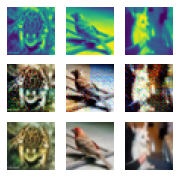

##############
For Epoch:136
Training Discriminator
Training Generator
Discriminator Loss:0.16255034793734532
Generator loss:0.6518357934951782


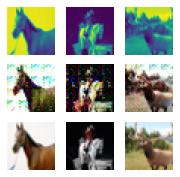

##############
For Epoch:137
Training Discriminator
Training Generator
Discriminator Loss:0.16254845085993083
Generator loss:0.6518382015228271


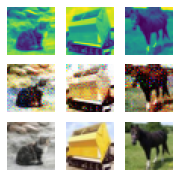

##############
For Epoch:138
Training Discriminator
Training Generator
Discriminator Loss:0.16254965635043786
Generator loss:0.6516635621190071


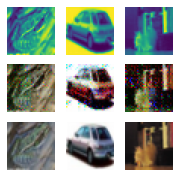

##############
For Epoch:139
Training Discriminator
Training Generator
Discriminator Loss:0.16257397207603802
Generator loss:0.6514675495028496


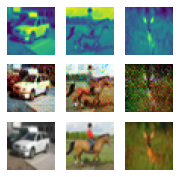

##############
For Epoch:140
Training Discriminator
Training Generator
Discriminator Loss:0.1626015676693278
Generator loss:0.6514744276404381


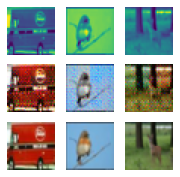

##############
For Epoch:141
Training Discriminator
Training Generator
Discriminator Loss:0.16255130675429397
Generator loss:0.6513451212644576


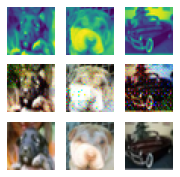

##############
For Epoch:142
Training Discriminator
Training Generator
Discriminator Loss:0.16255122629457866
Generator loss:0.6517139736413956


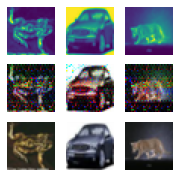

##############
For Epoch:143
Training Discriminator
Training Generator
Discriminator Loss:0.16254853608799544
Generator loss:0.6514502564072608


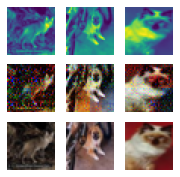

##############
For Epoch:144
Training Discriminator


In [ ]:

for epoch in range(epochs):
  print("##############")
  print("For Epoch:"+str(epoch))
  
  g_loss = 0
  d_loss = 0
  
  print("Training Discriminator")
  
  i = shuffle(range(n_example))
  
  dis.trainable = True
  dis.compile(loss = "binary_crossentropy",optimizer = adams)
  
  for j in range(dis_updates):
      
    for b in range(batches):
        
      x_batch = x[i[b*batch_size:(b+1)*batch_size]]
      y_batch = y[i[b*batch_size:(b+1)*batch_size]]
      
      pre_batch = gen.predict(x_batch)
      
      d_loss += dis.train_on_batch([x_batch,y_batch],one)
      d_loss += dis.train_on_batch([x_batch,pre_batch],zero)
      
  print("Training Generator")
  
  dis.trainable = False
  combined.compile(loss  = "binary_crossentropy", optimizer = adams)  
  dis.compile(loss = "binary_crossentropy",optimizer = adams)
        
  for  j in range(gen_updates):
    
    for b in range(batches):
      
      x_batch = x[i[b*batch_size:(b+1)*batch_size]]
      y_batch = y[i[b*batch_size:(b+1)*batch_size]]
      
        
      #in case the mode collapse takes place....commenting next two lines might help.
      #if b%4==3:
        #gl,_,_ = combined.train_on_batch([x_batch,y_batch],[zero,one])  
      
      gl,_,_ = combined.train_on_batch([x_batch,y_batch],[one,one])
      g_loss += gl
      
  g_loss /= g_loss_factor
  d_loss /= d_loss_factor
      
  print("Discriminator Loss:"+str(d_loss))
  print("Generator loss:"+str(g_loss))
  
  genLoss.append(g_loss)
  disLoss.append(d_loss)
  
  gen.save_weights("gdrive/My Drive/newGAN/Generator.h5")
  dis.save_weights("gdrive/My Drive/newGAN/Discriminator.h5")
  


  plt_indices = np.random.randint(50000,size=3)
  plt_a = x[plt_indices]
  plt_b = gen.predict(plt_a)
  plt_b = (plt_b+1)/2
  plt_c = (y[plt_indices]+1)/2
  fig = plot(plt_a,plt_b,plt_c,3)
  plt.show()
  plt.close(fig)
 


plt.plot(genLoss, c='r', label="Generator Loss")
plt.plot(disLoss, c='b', label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

files.download('gdrive/My Drive/GANModels/Generator.h5')
files.download('gdrive/My Drive/GANModels/Discriminator.h5')



#for recieving mail on completion of training.
server = smtplib.SMTP('smtp.gmail.com', 587)
server.starttls()
server.login("goeld9911@gmail.com", "deepika")
 
msg = "COLAB WORK FINISH ALERT!"
server.sendmail("goeld9911@gmail.com", "goeld9911@gmail.com", msg)
server.quit()
